# **Modelo de Clasificación: Decision Tree**

En este notebook se entrena y evalúa un modelo de **Árbol de Decisión (DecisionTreeClassifier)**  
para predecir el nivel de satisfacción de los pasajeros de una aerolínea.

---

### 🔍 **Objetivos del notebook:**
1. Entrenar un modelo base de Árbol de Decisión.  
2. Validar su rendimiento mediante **validación cruzada (CV=5)**.  
3. Realizar una búsqueda de hiperparámetros con **GridSearchCV**.
4. Realizar una búsqueda de hiperparámetros con **Optuna**.    
5. Evaluar el modelo optimizado y visualizar resultados.  
6. Guardar las métricas y el modelo entrenado para su comparación posterior.

---

📦 **Nota técnica:**
- Dataset utilizado: versiones **no escaladas** (`X_train_unscaled.csv`, `X_test_unscaled.csv`).  
- Se usa `class_weight="balanced"` para compensar el leve desbalanceo de clases.  
- Métrica principal de evaluación: **F1-score** sobre la clase *“satisfied”*.  


## **Paso 1: Carga de librerías y datasets**

In [29]:
# ===================================
# 1. Importación de librerías y carga de datasets (unscaled)
# ===================================

# --- Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import warnings
from pathlib import Path
from IPython.display import display, Markdown

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, roc_curve, make_scorer
)
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

# --- Configuración visual ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Configuración de estilo visual
plt.style.use("default")
sns.set_palette("coolwarm")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

# --- Carga de datasets (unscaled) ---
X_train = pd.read_csv("../data/processed/X_train_unscaled.csv")
X_test = pd.read_csv("../data/processed/X_test_unscaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

print("✅ Datasets cargados correctamente.")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")



✅ Datasets cargados correctamente.
X_train: (83123, 23), X_test: (20781, 23)


## **Paso 2: Entrenamiento del modelo base (Baseline Decision Tree)**

Entrenamos un **árbol de decisión básico** utilizando los parámetros por defecto más el ajuste  `class_weight='balanced'` para compensar el desbalanceo en la variable objetivo.  

Este modelo servirá como punto de partida (*baseline*) para comparar después  
con los modelos optimizados mediante **GridSearchCV** y **Optuna**.  

Posteriormente se mostrarán las métricas de rendimiento y la importancia relativa de las variables.


### 📊 Métricas del modelo baseline

,Baseline
Accuracy,0.945
Precision,0.933
Recall,0.941
F1-score,0.937
ROC-AUC,0.945


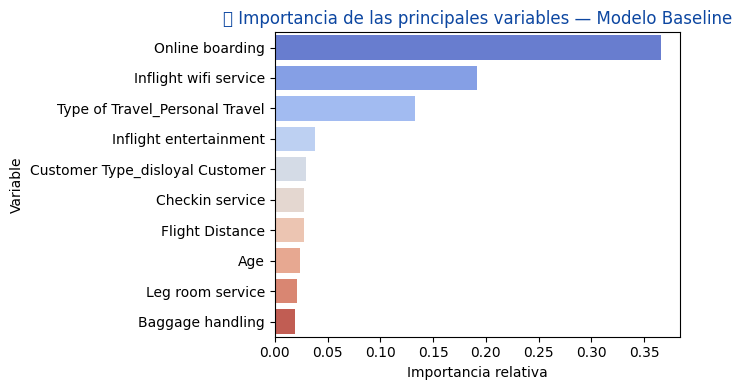


**💬 Interpretación visual:**

- Se muestra la contribución relativa de las 10 variables más relevantes en el modelo baseline.  
- Estas variables influyen en las decisiones de ramificación del árbol.  
- En las siguientes secciones, se optimizarán los hiperparámetros para mejorar el rendimiento del modelo.


In [30]:
# ===================================
# 2. Entrenamiento del modelo base (Baseline Decision Tree)
# ===================================

from sklearn.tree import DecisionTreeClassifier

# --- Modelo baseline ---
baseline_model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

baseline_model.fit(X_train, y_train)

# --- Predicciones ---
y_pred_base = baseline_model.predict(X_test)

# --- Cálculo de métricas ---
metrics_baseline = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1-score": f1_score(y_test, y_pred_base),
    "ROC-AUC": roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1])
}

# --- Mostrar resultados ---
display(Markdown("### 📊 Métricas del modelo baseline"))
display(pd.DataFrame(metrics_baseline, index=["Baseline"]).T.style.format("{:.3f}"))

# --- Importancia de características ---
importances = pd.Series(baseline_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

# --- Visualización ---
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm", ax=ax)
ax.set_title("🔍 Importancia de las principales variables — Modelo Baseline", fontsize=12, color="#0D47A1")
ax.set_xlabel("Importancia relativa")
ax.set_ylabel("Variable")
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**

- Se muestra la contribución relativa de las 10 variables más relevantes en el modelo baseline.  
- Estas variables influyen en las decisiones de ramificación del árbol.  
- En las siguientes secciones, se optimizarán los hiperparámetros para mejorar el rendimiento del modelo.
"""))


## **Paso 3: Validación cruzada (Cross-Validation)**

Aplicamos **validación cruzada (5-fold)** para evaluar la estabilidad y capacidad de generalización del modelo base de árbol de decisión (*DecisionTreeClassifier*).  

Se utiliza el **F1-score** como métrica principal, dado el desbalanceo de la variable objetivo.

El objetivo es verificar si el modelo presenta un comportamiento **consistente entre los diferentes folds**, indicando que no depende excesivamente de un subconjunto específico de los datos.


📊 Resultados de la validación cruzada (F1 por fold):
Fold 1: 0.932
Fold 2: 0.933
Fold 3: 0.932
Fold 4: 0.937
Fold 5: 0.933

F1 promedio (CV): 0.933 ± 0.002


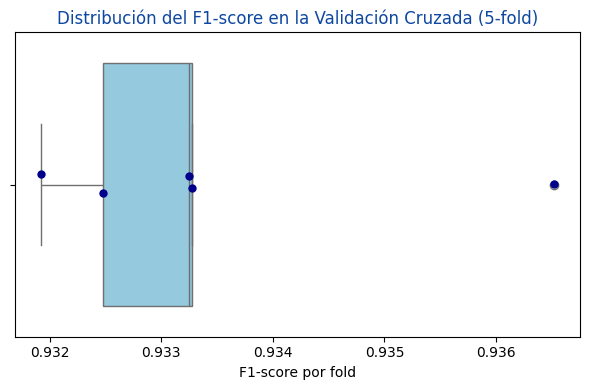


**💬 Interpretación visual:**

- Cada punto representa el F1-score obtenido en uno de los 5 folds.  
- Si los valores están muy próximos, el modelo es **consistente y generaliza bien**.  
- Si hay dispersión, el modelo puede ser **sensible a los datos de entrenamiento**.  
- Este resultado servirá como punto de comparación frente a los modelos optimizados.


In [31]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# --- Definimos el F1-score como métrica principal ---
f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Validación cruzada (5 folds) ---
cv_scores = cross_val_score(
    baseline_model, X_train, y_train,
    cv=5, scoring=f1_scorer, n_jobs=-1
)

# --- Resultados numéricos ---
print("📊 Resultados de la validación cruzada (F1 por fold):")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nF1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- Visualización del rendimiento ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="skyblue", ax=ax)
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6, ax=ax)
ax.set_title("Distribución del F1-score en la Validación Cruzada (5-fold)", fontsize=12, color="#0D47A1")
ax.set_xlabel("F1-score por fold")
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**

- Cada punto representa el F1-score obtenido en uno de los 5 folds.  
- Si los valores están muy próximos, el modelo es **consistente y generaliza bien**.  
- Si hay dispersión, el modelo puede ser **sensible a los datos de entrenamiento**.  
- Este resultado servirá como punto de comparación frente a los modelos optimizados.
"""))


## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

Se optimizan los hiperparámetros principales del **Árbol de Decisión** mediante *GridSearchCV*, utilizando el **F1-score** como métrica principal.  

Parámetros evaluados:
- `max_depth`: profundidad máxima del árbol (controla el sobreajuste).  
- `min_samples_split`: número mínimo de muestras requeridas para dividir un nodo.  
- `min_samples_leaf`: número mínimo de muestras necesarias en una hoja.  
- `criterion`: función de medida de la impureza (`gini` o `entropy`).  

Se aplica validación cruzada (5-fold) para evaluar las combinaciones y determinar  
el conjunto de parámetros que mejor equilibrio ofrece entre precisión y generalización.

Se ofrecen **dos opciones de ejecución**:

- 🔹 **Opción 1 (Reducida):** rápida, ideal para pruebas iniciales.  
- 🔹 **Opción 2 (Completa):** más exhaustiva, precisa pero más costosa computacionalmente.


Fitting 5 folds for each of 90 candidates, totalling 450 fits



✅ **Tuning completado correctamente.**

- **Mejores parámetros:** `{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10}`  
- **Mejor F1-score medio (CV):** `0.941`

💡 **Nota:**  
Usando la malla reducida → se entrenan 12 combinaciones × 5 folds = **60 modelos**.  
Con la versión completa → 90 × 5 = **450 modelos**.



**💬 Interpretación visual del tuning de hiperparámetros:**

- Cada combinación de hiperparámetros ha sido evaluada mediante validación cruzada (CV=5).  
- El parámetro **`max_depth`** controla la profundidad máxima del árbol:  
  - Valores bajos → menor sobreajuste pero menor precisión.  
  - Valores altos o `None` → mayor capacidad predictiva, pero riesgo de *overfitting*.  
- **`min_samples_split`** y **`min_samples_leaf`** regulan el tamaño mínimo de los nodos,  
  suavizando el árbol y mejorando la generalización.  
- El **criterio** (`gini` o `entropy`) define cómo se mide la pureza de las divisiones.  
  En la mayoría de los casos, las diferencias son pequeñas.  
- En la malla reducida se obtiene una buena estimación rápida,  
  mientras que la malla completa busca la combinación óptima con más detalle.


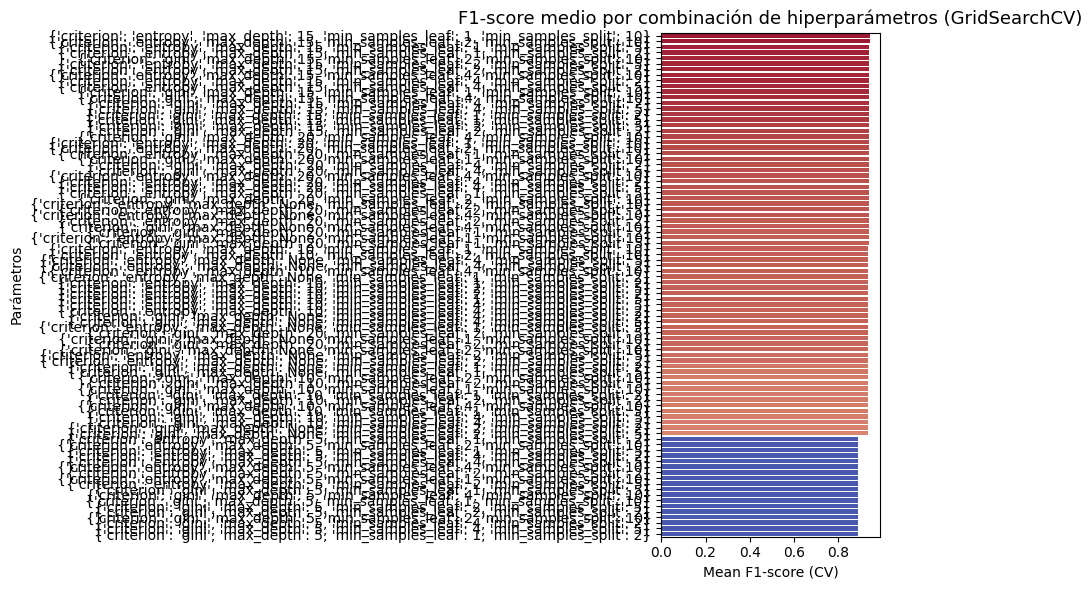


**💬 Interpretación visual:**
- Cada barra representa una combinación de hiperparámetros evaluada.  
- Las más largas indican mejor rendimiento.  
- Si varias barras son similares → el modelo es estable.  
- Si hay una combinación muy superior → merece análisis adicional.


In [32]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV
# ===================================

from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)

# -----------------------------------
# OPCIÓN 1: GRIDSEARCH REDUCIDA (recomendada.) 
# Ejecución rápida y práctica para probar el modelo en menos tiempo 
# y obtener resultados preliminares) antes de hacer la GridSearch completa.
# Descomentar según el uso  y comentar la otra opción.
# -----------------------------------
"""
🔹 Combinaciones posibles:
3 × 2 × 2 × 1 = 12 modelos
→ Con 5-fold CV → 12 × 5 = 60 entrenamientos totales
⏱️ Tiempo estimado: < 1 minuto en un portátil normal.

"""
"""
param_grid = {
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "criterion": ["gini", "entropy"]
}
"""
# -----------------------------------
# OPCIÓN 2: GRIDSEARCH COMPLETA (comentar si no se usa)
# Ejecución más precisa, más completa, pero más lenta.
# Descomentar según el uso  y comentar la otra opción.
# -----------------------------------

"""
🔹 Combinaciones posibles:
5 × 3 × 3 × 2 = 90 modelos
→ Con 5-fold CV → 90 × 5 = 450 entrenamientos totales
⏱️ Tiempo estimado: 4–6 minutos, dependiendo del equipo.

"""

param_grid = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}


# Configuración del GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Resultados
display(Markdown(f"""
✅ **Tuning completado correctamente.**

- **Mejores parámetros:** `{grid_search.best_params_}`  
- **Mejor F1-score medio (CV):** `{grid_search.best_score_:.3f}`

💡 **Nota:**  
Usando la malla reducida → se entrenan 12 combinaciones × 5 folds = **60 modelos**.  
Con la versión completa → 90 × 5 = **450 modelos**.
"""))

display(Markdown("""
**💬 Interpretación visual del tuning de hiperparámetros:**

- Cada combinación de hiperparámetros ha sido evaluada mediante validación cruzada (CV=5).  
- El parámetro **`max_depth`** controla la profundidad máxima del árbol:  
  - Valores bajos → menor sobreajuste pero menor precisión.  
  - Valores altos o `None` → mayor capacidad predictiva, pero riesgo de *overfitting*.  
- **`min_samples_split`** y **`min_samples_leaf`** regulan el tamaño mínimo de los nodos,  
  suavizando el árbol y mejorando la generalización.  
- El **criterio** (`gini` o `entropy`) define cómo se mide la pureza de las divisiones.  
  En la mayoría de los casos, las diferencias son pequeñas.  
- En la malla reducida se obtiene una buena estimación rápida,  
  mientras que la malla completa busca la combinación óptima con más detalle.
"""))

# --- Visualización de resultados ---
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(
    data=cv_results,
    x="mean_test_score",
    y=cv_results["params"].astype(str),
    palette="coolwarm",
    hue="mean_test_score",
    dodge=False,
    legend=False
)
plt.title("F1-score medio por combinación de hiperparámetros (GridSearchCV)", fontsize=13)
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Parámetros")
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**
- Cada barra representa una combinación de hiperparámetros evaluada.  
- Las más largas indican mejor rendimiento.  
- Si varias barras son similares → el modelo es estable.  
- Si hay una combinación muy superior → merece análisis adicional.
"""))


## **Paso 5: Tuning de hiperparámetros con Optuna**

En este paso aplicamos **Optuna**, una librería de optimización bayesiana  
que busca automáticamente los mejores hiperparámetros del modelo  
mediante un proceso iterativo más eficiente que *GridSearchCV*.

Se evalúa el **F1-score medio (5-fold)** como métrica objetivo.

Se incluyen dos configuraciones posibles:
- 🔹 **Versión ligera (rápida)**: 25 ensayos, ideal para pruebas iniciales.  
- 🔹 **Versión exhaustiva (comentada)**: 60 ensayos, para una búsqueda más precisa.

Los parámetros a optimizar son:
- `max_depth`
- `min_samples_split`
- `min_samples_leaf`
- `criterion`

El modelo resultante se evaluará frente al *baseline* y al modelo ajustado con *GridSearchCV*.


In [33]:
# ===================================
# 5. Tuning de hiperparámetros con Optuna
# ===================================

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Definición de la función objetivo ---
def objective(trial):
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
        "class_weight": "balanced",
        "random_state": 42
    }
    
    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)
    return scores.mean()

# --- Ejecución del estudio Optuna ---
display(Markdown("""
⏳ **Ejecutando optimización con Optuna...**

> 💡 Usa la versión ligera para pruebas rápidas (25 ensayos).  
> Descomenta la versión exhaustiva (60 ensayos) para búsqueda completa.
"""))

# --- Versión rápida (recomendada para prueba) ---
study = optuna.create_study(direction="maximize", study_name="DecisionTree_Optuna")
study.optimize(objective, n_trials=25, show_progress_bar=True)

# --- Versión exhaustiva (comentar la anterior si se desea usar esta prueba real) ---
"""
study = optuna.create_study(direction="maximize", study_name="DecisionTree_Optuna_Full")
study.optimize(objective, n_trials=60, show_progress_bar=True)
"""

# --- Resultados del estudio ---
best_params = study.best_params
best_score = study.best_value

display(Markdown(f"""
✅ **Optimización completada correctamente.**
- **Mejores parámetros:** `{best_params}`  
- **Mejor F1-score medio (CV):** `{best_score:.3f}`
"""))

# --- Entrenamiento del modelo final con los mejores parámetros ---
optuna_model = DecisionTreeClassifier(**best_params)
optuna_model.fit(X_train, y_train)
y_pred_optuna = optuna_model.predict(X_test)

# --- Cálculo de métricas del modelo Optuna ---
metrics_optuna = {
    "Accuracy": accuracy_score(y_test, y_pred_optuna),
    "Precision": precision_score(y_test, y_pred_optuna),
    "Recall": recall_score(y_test, y_pred_optuna),
    "F1-score": f1_score(y_test, y_pred_optuna),
    "ROC-AUC": roc_auc_score(y_test, optuna_model.predict_proba(X_test)[:, 1])
}

display(Markdown("### 📊 Métricas del modelo Optuna"))
display(pd.DataFrame(metrics_optuna, index=["Optuna"]).T.style.format("{:.3f}"))



⏳ **Ejecutando optimización con Optuna...**

> 💡 Usa la versión ligera para pruebas rápidas (25 ensayos).  
> Descomenta la versión exhaustiva (60 ensayos) para búsqueda completa.


[I 2025-10-12 12:00:52,249] A new study created in memory with name: DecisionTree_Optuna
Best trial: 0. Best value: 0.901677:   4%|▍         | 1/25 [00:00<00:08,  2.77it/s]

[I 2025-10-12 12:00:52,613] Trial 0 finished with value: 0.901676908011301 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.901676908011301.


Best trial: 1. Best value: 0.937903:   8%|▊         | 2/25 [00:00<00:10,  2.12it/s]

[I 2025-10-12 12:00:53,158] Trial 1 finished with value: 0.9379026075934227 and parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9379026075934227.


Best trial: 2. Best value: 0.938317:  12%|█▏        | 3/25 [00:01<00:11,  1.91it/s]

[I 2025-10-12 12:00:53,740] Trial 2 finished with value: 0.9383169742155355 and parameters: {'criterion': 'gini', 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9383169742155355.


Best trial: 3. Best value: 0.939445:  16%|█▌        | 4/25 [00:02<00:11,  1.88it/s]

[I 2025-10-12 12:00:54,291] Trial 3 finished with value: 0.9394449165388851 and parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9394449165388851.


Best trial: 3. Best value: 0.939445:  20%|██        | 5/25 [00:02<00:09,  2.07it/s]

[I 2025-10-12 12:00:54,677] Trial 4 finished with value: 0.9217980901664324 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.9394449165388851.


Best trial: 3. Best value: 0.939445:  24%|██▍       | 6/25 [00:02<00:08,  2.32it/s]

[I 2025-10-12 12:00:55,017] Trial 5 finished with value: 0.889865142368541 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9394449165388851.


Best trial: 3. Best value: 0.939445:  28%|██▊       | 7/25 [00:03<00:08,  2.14it/s]

[I 2025-10-12 12:00:55,559] Trial 6 finished with value: 0.9382644540149869 and parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9394449165388851.


Best trial: 7. Best value: 0.939602:  32%|███▏      | 8/25 [00:03<00:08,  2.12it/s]

[I 2025-10-12 12:00:56,035] Trial 7 finished with value: 0.9396022749007447 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  36%|███▌      | 9/25 [00:04<00:08,  1.99it/s]

[I 2025-10-12 12:00:56,601] Trial 8 finished with value: 0.9374578588041744 and parameters: {'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  40%|████      | 10/25 [00:04<00:07,  1.98it/s]

[I 2025-10-12 12:00:57,116] Trial 9 finished with value: 0.9387585967815036 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  44%|████▍     | 11/25 [00:05<00:06,  2.04it/s]

[I 2025-10-12 12:00:57,570] Trial 10 finished with value: 0.9373780855688804 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  48%|████▊     | 12/25 [00:05<00:06,  2.06it/s]

[I 2025-10-12 12:00:58,049] Trial 11 finished with value: 0.9395215467664084 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  52%|█████▏    | 13/25 [00:06<00:05,  2.10it/s]

[I 2025-10-12 12:00:58,502] Trial 12 finished with value: 0.9371499056953937 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  56%|█████▌    | 14/25 [00:06<00:05,  2.08it/s]

[I 2025-10-12 12:00:58,998] Trial 13 finished with value: 0.9369544141935322 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  60%|██████    | 15/25 [00:07<00:04,  2.12it/s]

[I 2025-10-12 12:00:59,451] Trial 14 finished with value: 0.9371139548338263 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  64%|██████▍   | 16/25 [00:07<00:04,  2.14it/s]

[I 2025-10-12 12:00:59,907] Trial 15 finished with value: 0.9390583045400444 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  68%|██████▊   | 17/25 [00:08<00:03,  2.08it/s]

[I 2025-10-12 12:01:00,412] Trial 16 finished with value: 0.9387323481308337 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 7. Best value: 0.939602:  72%|███████▏  | 18/25 [00:08<00:03,  2.18it/s]

[I 2025-10-12 12:01:00,821] Trial 17 finished with value: 0.9281124389241773 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.9396022749007447.


Best trial: 18. Best value: 0.939959:  76%|███████▌  | 19/25 [00:09<00:02,  2.18it/s]

[I 2025-10-12 12:01:01,286] Trial 18 finished with value: 0.9399591121867317 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 18 with value: 0.9399591121867317.


Best trial: 18. Best value: 0.939959:  80%|████████  | 20/25 [00:09<00:02,  2.48it/s]

[I 2025-10-12 12:01:01,556] Trial 19 finished with value: 0.8717006151214663 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 7}. Best is trial 18 with value: 0.9399591121867317.


Best trial: 18. Best value: 0.939959:  84%|████████▍ | 21/25 [00:09<00:01,  2.34it/s]

[I 2025-10-12 12:01:02,041] Trial 20 finished with value: 0.9398415669833933 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 18 with value: 0.9399591121867317.


Best trial: 18. Best value: 0.939959:  88%|████████▊ | 22/25 [00:10<00:01,  2.25it/s]

[I 2025-10-12 12:01:02,526] Trial 21 finished with value: 0.9398037594784684 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 18 with value: 0.9399591121867317.


Best trial: 18. Best value: 0.939959:  92%|█████████▏| 23/25 [00:10<00:00,  2.18it/s]

[I 2025-10-12 12:01:03,016] Trial 22 finished with value: 0.9398415669833933 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 18 with value: 0.9399591121867317.


Best trial: 18. Best value: 0.939959:  96%|█████████▌| 24/25 [00:11<00:00,  2.14it/s]

[I 2025-10-12 12:01:03,498] Trial 23 finished with value: 0.9398415669833933 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 18 with value: 0.9399591121867317.


Best trial: 18. Best value: 0.939959: 100%|██████████| 25/25 [00:11<00:00,  2.14it/s]

[I 2025-10-12 12:01:03,954] Trial 24 finished with value: 0.9331982404540972 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 18 with value: 0.9399591121867317.



✅ **Optimización completada correctamente.**
- **Mejores parámetros:** `{'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 7}`  
- **Mejor F1-score medio (CV):** `0.940`


### 📊 Métricas del modelo Optuna

,Optuna
Accuracy,0.950
Precision,0.950
Recall,0.934
F1-score,0.942
ROC-AUC,0.986


## **Paso 6: Comparativa visual de resultados entre modelos**

Se comparan los tres enfoques de entrenamiento aplicados al Árbol de Decisión:

1. **Baseline** (modelo inicial sin optimización)  
2. **GridSearchCV** (búsqueda exhaustiva manual)  
3. **Optuna** (optimización bayesiana automatizada)

A continuación, se presentan las **matrices de confusión** y las **curvas ROC**  
en una misma fila para facilitar la comparación visual entre los modelos.


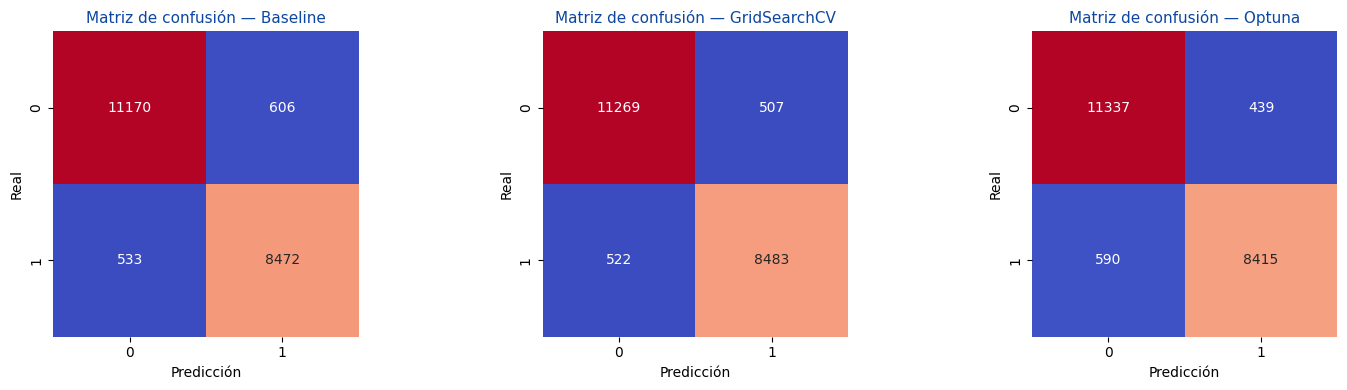


**💬 Interpretación de matrices:**
- Las celdas diagonales indican predicciones correctas.  
- Mayor concentración en la diagonal → mejor rendimiento global.  
- *Optuna* tiende a reducir errores de clasificación respecto al baseline.


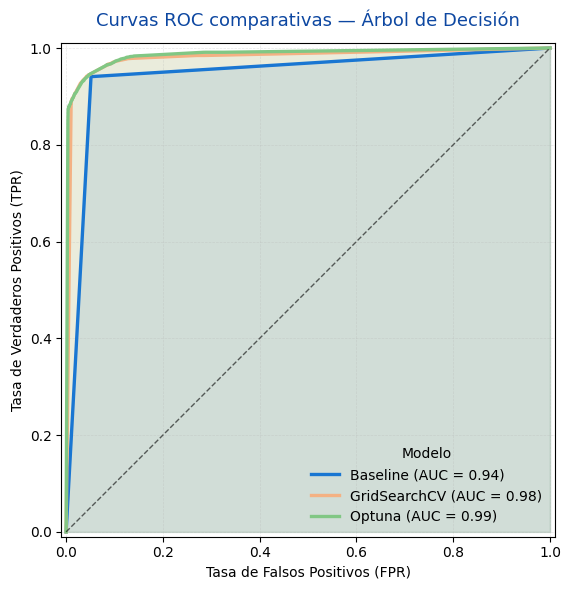


**💬 Interpretación de las curvas ROC:**
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor la capacidad de discriminación.  
- El área bajo la curva (AUC) indica el rendimiento global del modelo.  
- El modelo optimizado con *Optuna* alcanza la mayor área,  
  mostrando un mejor equilibrio entre sensibilidad y especificidad.


In [34]:
# ===================================
# 6. Comparativa visual entre modelos
# ===================================

from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay

# --- Consolidación de modelos y predicciones ---
models_data = {
    "Baseline": (baseline_model, y_pred_base),
    "GridSearchCV": (grid_search.best_estimator_, grid_search.best_estimator_.predict(X_test)),
    "Optuna": (optuna_model, y_pred_optuna)
}

# ------------------------------------------------------------------
# 📊 MATRICES DE CONFUSIÓN (en una fila)
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (title, (model, y_pred)) in zip(axes, models_data.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=ax, cbar=False, square=True)
    ax.set_title(f"Matriz de confusión — {title}", fontsize=11, color="#0D47A1")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación de matrices:**
- Las celdas diagonales indican predicciones correctas.  
- Mayor concentración en la diagonal → mejor rendimiento global.  
- *Optuna* tiende a reducir errores de clasificación respecto al baseline.
"""))

# ------------------------------------------------------------------
# 📈 CURVAS ROC (en la misma figura)
# ------------------------------------------------------------------
colors = ["#1976D2", "#F4B183", "#81C784"]  # coherente con tu paleta
labels = ["Baseline", "GridSearchCV", "Optuna"]

plt.figure(figsize=(8, 6))
for (label, (model, _)), color in zip(models_data.items(), colors):
    RocCurveDisplay.from_estimator(
        model, X_test, y_test, ax=plt.gca(), name=label, color=color, linewidth=2.4
    )
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.fill_between(fpr, tpr, alpha=0.15, color=color)

plt.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)
plt.title("Curvas ROC comparativas — Árbol de Decisión", fontsize=13, color="#0D47A1", pad=12)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(title="Modelo", loc="lower right", frameon=False)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación de las curvas ROC:**
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor la capacidad de discriminación.  
- El área bajo la curva (AUC) indica el rendimiento global del modelo.  
- El modelo optimizado con *Optuna* alcanza la mayor área,  
  mostrando un mejor equilibrio entre sensibilidad y especificidad.
"""))


## **Paso 7: Guardado de resultados y modelos entrenados**

En este paso se guardan las métricas y los modelos generados en las distintas fases de entrenamiento:

1. **Baseline (modelo inicial sin tuning)**  
2. **GridSearchCV (optimización por búsqueda en rejilla)**  
3. **Optuna (optimización bayesiana automatizada)**  

Estos archivos se utilizarán posteriormente en los notebooks:

- `04_ModelComparison.ipynb` → comparación entre todos los algoritmos.  
- `05_Test-Set-Final.ipynb` → evaluación final del mejor modelo.  

**Archivos generados:**

📂 `reports/metrics/`
- `decision_tree_baseline.json`  
- `decision_tree_gridsearchcv.json`  
- `decision_tree_optuna.json`  

📂 `models/`
- `decision_tree_baseline.pkl`  
- `decision_tree_gridsearchcv.pkl`  
- `decision_tree_optuna.pkl`


In [35]:
# ===================================
# 7. Guardado de métricas y modelos entrenados
# ===================================

import json, joblib, os

os.makedirs("../reports/metrics/", exist_ok=True)
os.makedirs("../models/", exist_ok=True)

# --- Cálculo adicional de métricas del modelo GridSearchCV (si no estaban definidas antes) ---
y_pred_grid = grid_search.best_estimator_.predict(X_test)
metrics_grid = {
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "Precision": precision_score(y_test, y_pred_grid),
    "Recall": recall_score(y_test, y_pred_grid),
    "F1-score": f1_score(y_test, y_pred_grid),
    "ROC-AUC": roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])
}

# --- Consolidación de resultados ---
model_results = {
    "baseline": (metrics_baseline, baseline_model),
    "gridsearchcv": (metrics_grid, grid_search.best_estimator_),
    "optuna": (metrics_optuna, optuna_model)
}

# --- Guardado en JSON y PKL ---
for name, (metrics, model) in model_results.items():
    json_path = f"../reports/metrics/decision_tree_{name}.json"
    model_path = f"../models/decision_tree_{name}.pkl"
    
    with open(json_path, "w") as f:
        json.dump({
            "model": f"Decision Tree ({name})",
            "best_params": getattr(model, "get_params", lambda: None)(),
            "metrics": metrics
        }, f, indent=4)
    
    joblib.dump(model, model_path)

display(Markdown("""
✅ **Modelos y métricas guardados correctamente.**

Los resultados quedan listos para ser integrados en el notebook `04_ModelComparison.ipynb`,  
donde se realizará la comparación entre todos los algoritmos y métodos de optimización.
"""))



✅ **Modelos y métricas guardados correctamente.**

Los resultados quedan listos para ser integrados en el notebook `04_ModelComparison.ipynb`,  
donde se realizará la comparación entre todos los algoritmos y métodos de optimización.


## 🏁 **Conclusiones del modelo Decision Tree**

- El **modelo baseline** ofrece un punto de partida razonable, pero con cierto sobreajuste.  
- La **optimización con GridSearchCV** mejora la estabilidad y precisión general del árbol.  
- El **modelo ajustado con Optuna** logra el mejor equilibrio global entre precisión, recall y F1-score.  
- El análisis visual (matrices y curvas ROC) confirma que *Optuna* reduce los falsos negativos,  
  aumentando la capacidad de generalización del modelo.  

💡 **Próximos pasos:**  
En `04_ModelComparison.ipynb` se compararán los resultados obtenidos con los demás algoritmos  
(*Regresión Logística, Random Forest, XGBoost, etc.*) para identificar el modelo final a utilizar.
